In [90]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
from string import punctuation
from sklearn.svm import SVC


In [91]:
train_df = pd.read_csv('train.csv', delimiter=',', encoding='ISO-8859-1')

# Drop duplicates
train_df = train_df.drop_duplicates('text')

In [92]:
# Preprocessing function
def text_processing(text):
    text = str(text).lower()
    text = re.sub(r"https?\S+|www\S+|https?\S+", " ", text)
    text = re.sub(r'\@\w+|\#', " ", text)
    text = re.sub(r'[^\w\s\`]', " ", text)
    text = ' '.join([word for word in text.split() if word not in punctuation])
    return text

In [93]:
# Apply preprocessing
train_df['text'] = train_df['text'].apply(text_processing)

# Replace sentiment labels
train_df['sentiment'].replace('negative', 0, inplace=True)
train_df['sentiment'].replace('neutral', 2, inplace=True)
train_df['sentiment'].replace('positive', 4, inplace=True)

# Downsample the majority and minority classes
df_majority = train_df[train_df['sentiment'] == 0]
df_neutral = train_df[train_df['sentiment'] == 2]
df_minority = train_df[train_df['sentiment'] == 4]

C:\Users\mundh\AppData\Local\Temp\ipykernel_15840\2592439779.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['sentiment'].replace('negative', 0, inplace=True)
C:\Users\mundh\AppData\Local\Temp\ipykernel_15840\2592439779.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [94]:
#df_majority_downsampled = resample(df_majority, replace=False, n_samples=len(df_neutral)//3, random_state=134)
#df_minority_downsampled = resample(df_minority, replace=False, n_samples=len(df_neutral)//3, random_state=134)

train_df = pd.concat([df_majority, df_neutral, df_minority])

# Vectorize the text data
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(train_df['text'])

In [95]:
# Read the test dataset
test_df = pd.read_csv('test.csv', delimiter=',', encoding='ISO-8859-1')

# Drop duplicates
test_df = test_df.drop_duplicates('text')

In [96]:
# Apply preprocessing
test_df['text'] = test_df['text'].apply(text_processing)

# Replace sentiment labels
test_df['sentiment'].replace('negative', 0, inplace=True)
test_df['sentiment'].replace('neutral', 2, inplace=True)
test_df['sentiment'].replace('positive', 4, inplace=True)



C:\Users\mundh\AppData\Local\Temp\ipykernel_15840\1009205166.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['sentiment'].replace('negative', 0, inplace=True)
C:\Users\mundh\AppData\Local\Temp\ipykernel_15840\1009205166.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [97]:
# Downsample the majority and minority classes
df_majority_01 = test_df[test_df['sentiment'] == 0]
df_neutral_01 = test_df[test_df['sentiment'] == 2]
df_minority_01 = test_df[test_df['sentiment'] == 4]

#df_majority_downsampled = resample(df_majority_01, replace=False, n_samples=len(df_neutral_01)//3, random_state=134)
#df_minority_downsampled = resample(df_minority_01, replace=False, n_samples=len(df_neutral_01)//3, random_state=134)

df = pd.concat([df_majority_01, df_neutral_01, df_minority_01])

In [98]:
X = train_df['text']
y = train_df['sentiment']

# Vectorize the text data
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(X)
X_train = vectors
y_train = y
X_test = vectorizer.transform(df['text'])
y_test = df['sentiment']

In [99]:
# X_train, X_temp, y_train, y_temp = train_test_split(vectors, y, test_size=0.0000000000001, random_state=52)
# X_validation, X_test, y_validation, y_test = train_test_split(vectors, y, test_size=0.1, random_state=52)

In [100]:
# Reduce dimensionality with TruncatedSVD
n_components = 1000 
svd = TruncatedSVD(n_components=n_components)
X_train_pca = svd.fit_transform(X_train)
X_test_pca = svd.transform(X_test)

In [101]:
# Train a Linear SVM model
svm_model = LinearSVC(dual=True)
svm_model.fit(X_train_pca, y_train)

LinearSVC(dual=True)

Accuracy on the validation set: 0.6975099037917374


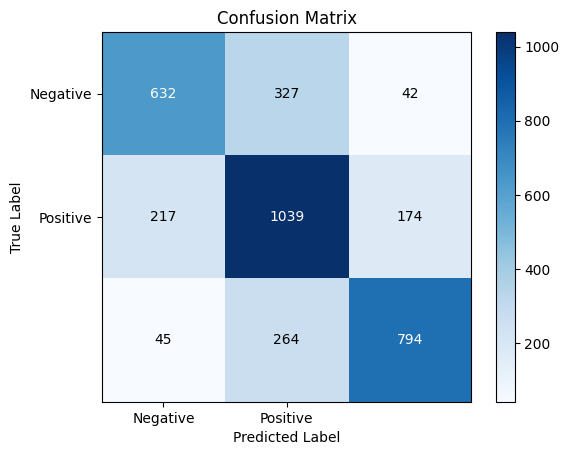

In [102]:
# Predictions on validation set
y_pred = svm_model.predict(X_test_pca)
accuracy_validation = accuracy_score(y_test, y_pred)
print(f"Accuracy on the validation set: {accuracy_validation}")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.show()


Accuracy on the validation set: 0.6983588002263724


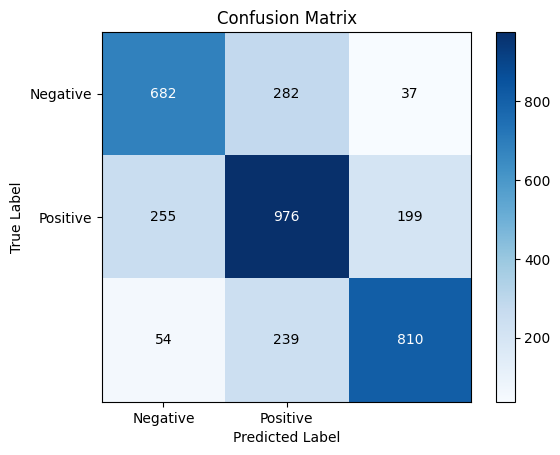

In [103]:
# Calibration
classifier = CalibratedClassifierCV(LinearSVC(dual=True), method='sigmoid')
classifier.fit(X_train, y_train)
y_pred_test = classifier.predict(X_test)
print(f"Accuracy on the validation set: {accuracy_score(y_test, y_pred_test)}")
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(2), ['Negative', 'Positive'])
plt.yticks(np.arange(2), ['Negative', 'Positive'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
plt.show()

In [104]:
# Function to predict sentiment for a given text
def predict_sentiment(text):
    text = text_processing(text)
    text_vector = vectorizer.transform([text])
    text_vector_pca = svd.transform(text_vector)
    prediction = classifier.predict(text_vector)
    if prediction[0] == 0:
        return "Negative"
    elif prediction[0] == 2:
        return "Neutral"
    else:
        return "Positive"

In [105]:
# Test some sentences manually
sentence = "I am happy that he died"
sentiment = predict_sentiment(sentence)
print(f"Sentence: {sentence} - Predicted Sentiment: {sentiment}")

Sentence: I am happy that he died - Predicted Sentiment: Positive
